In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [41]:
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Housing2')

<Experiment: artifact_location='file:///c:/Users/Victoria/gt/MLOp/Housing_Prediction/experiments_tracking/mlruns/3', creation_time=1713784164751, experiment_id='3', last_update_time=1713784164751, lifecycle_stage='active', name='Housing2', tags={}>

In [42]:
df = pd.read_csv('C:/Users/Victoria/gt/MLOp/Housing_Prediction/Training.csv')

In [43]:
import pandas as pd
def read_dataframe(filename):
    df = pd.read_csv(filename)
    df = df.drop('Id', axis=1)
    df = df.drop(columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

    df = df[df.Neighborhood == 'Avondale']
    df = df[(df.SalePrice >= 100000) & (df.SalePrice <= 500000)]

    categorical = ['BedroomAbvGr', 'GarageCars']
    df[categorical].astype(str)

    return df

# df[categorical].astype(str).dtypes


In [44]:
df_train = read_dataframe('C:/Users/Victoria/gt/MLOp/Housing_Prediction/Training.csv')
df_val = read_dataframe('C:/Users/Victoria/gt/MLOp/Housing_Prediction/Validation.csv')

In [45]:
len(df_train), len(df_val)

(288, 49)

In [47]:
df_train['BedroomAbvGr'] = df_train['BedroomAbvGr'].astype(str)
df_train['GarageCars'] = df_train['GarageCars'].astype(str)

df_train['BED_GAR'] = df_train['BedroomAbvGr'] + '_' + df_train['GarageCars']

df_val['BedroomAbvGr'] = df_val['BedroomAbvGr'].astype(str)
df_val['GarageCars'] = df_val['GarageCars'].astype(str)

df_val['BED_GAR'] = df_val['BedroomAbvGr'] + '_' + df_val['GarageCars']


In [ ]:
df_val

In [48]:
categorical = ['BED_GAR']#'BedroomAbvGr', 'GarageCars']
numerical = ['GarageArea']

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [49]:
target = 'SalePrice'
y_train = df_train[target].values
y_val = df_val[target].values

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

36147.195326956426

In [53]:
la = Lasso(alpha=10000000)
la.fit(X_train, y_train)

y_pred = la.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

25833.66489247413

In [54]:
if not os.path.exists('models'):
    os.makedirs('models')

# original code to save the file
with open('models/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, la), f_out)

In [61]:
mlflow.end_run()

with mlflow.start_run():

    mlflow.set_tag('Developer', 'Victoria')

    mlflow.log_param('Train', 'C:/Users/Victoria/gt/MLOp/Housing_Prediction/Training.csv')
    mlflow.log_param('Valid', 'C:/Users/Victoria/gt/MLOp/Housing_Prediction/Validation.csv')
    
    alpha=100000000
    mlflow.log_param('alpha', alpha)
    lr = Ridge(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

    mlflow.log_artifact(local_path='models/lasso.bin', artifact_path='models_pickle/lasso.bin')

In [ ]:
pip install hyperopt

In [57]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [58]:
def objective(params):
      #  params = log and visualize parameters using MLflow
  with mlflow.start_run():
     mlflow.set_tag('model', 'xgboost')
     mlflow.log_params(params)
     booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
     )
     y_pred = booster.predict(valid)
     rmse = mean_squared_error(y_val, y_pred, squared=False)
     mlflow.log_metric('rmse', rmse)

  return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lamba', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

In [ ]:
best_params = {
    'learning_rate': 0.06817254433679483,
     'max_depth': 4,
    'min_child_weight': 5.342622580585712,
    'objective': 'reg:linear',
    'reg_alpha': 0.03767824771170366,
    'reg_lambda': 0.11142683044900038,
    'seed': 42
}
mlflow.xgboost.autolog()

booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

In [71]:
mlflow.xgboost.autolog(disable=True)

In [ ]:
mlflow.end_run()
with mlflow.start_run():
   train = xgb.DMatrix(X_train, label=y_train)
   valid = xgb.DMatrix(X_val, label=y_val)
    
   best_params = {
      'learning_rate': 0.06817254433679483,
      'max_depth': 4,
      'min_child_weight': 5.342622580585712,
      'objective': 'reg:linear',
      'reg_alpha': 0.03767824771170366,
      'reg_lambda': 0.11142683044900038,
      'seed': 42
}
    
mlflow.log_params(best_params)

booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

y_pred = booster.predict(valid)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric('rmse', rmse)

with open('models/preprocessor.b', 'wb') as f_out:
   pickle.dump(dv, f_out)

mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')
mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

In [75]:
logged_model = 'runs:/cf03d113f2de4428833adc7d03f305da/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(logged_model)

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [78]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

c:\Users\Victoria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [80]:
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([131762.06, 162769.56, 162769.56, 134642.2 , 188166.64, 153808.88,
       133204.77, 133204.77, 134396.81, 131762.06], dtype=float32)

C:\Users\2024\AppData\Local\Temp\ipykernel_1344\1505421196.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\2024\AppData\Local\Temp\ipykernel_1344\1505421196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


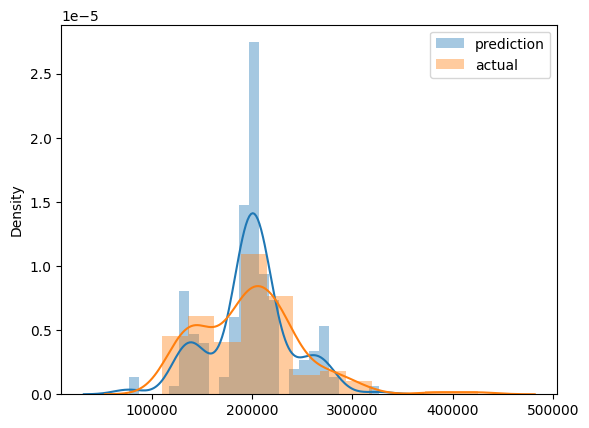

In [113]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

c:\Users\2024\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


31648.219425044535